<a href="https://colab.research.google.com/github/SachinVerma88/Stock-Market-Prediction/blob/main/DT_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df = pd.read_csv("/content/TATAMOTORS STOCK.csv")

In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df["Day"] = df["Date"].dt.dayofweek
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["Q"] = df["Date"].dt.quarter
df["Dayofyear"] = df["Date"].dt.dayofyear
df["Dayofmonth"] = df["Date"].dt.day
df["Weekofyear"] = df["Date"].dt.weekofyear
df["Drop_me"] = df["Date"].dt.strftime("%m-%d")
df.index = df["Date"]
df = df.drop(["Date"],axis=1)

<ipython-input-3-6998a02aef29>:8: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df["Weekofyear"] = df["Date"].dt.weekofyear


In [ ]:
df["Close"].head()

Date
2018-01-10    433.299988
2018-01-11    434.750000
2018-01-12    437.100006
2018-01-15    432.350006
2018-01-16    421.899994
Name: Close, dtype: float64

/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.8/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

Text(0.5, 1.0, 'Q4 - Price')

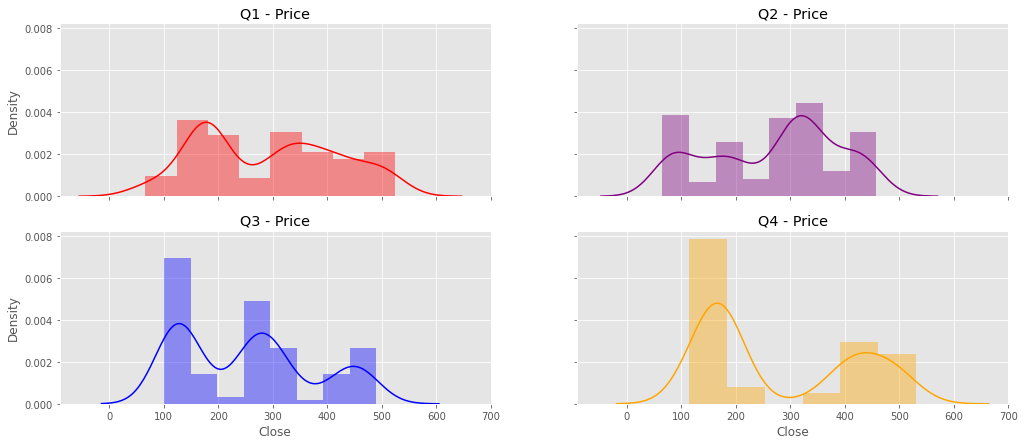

In [ ]:

Q1 = df[df["Q"]==1]
Q2 = df[df["Q"]==2]
Q3 = df[df["Q"]==3]
Q4 = df[df["Q"]==4]

fig,axes = plt.subplots(2,2,figsize=(17,7),sharex=True,sharey=True)

sns.distplot(Q1["Close"],color="red", ax=axes[0,0]).set_title("Q1 - Price")
sns.distplot(Q2["Close"],color="purple", ax=axes[0,1]).set_title("Q2 - Price")
sns.distplot(Q3["Close"],color="blue", ax=axes[1,0]).set_title("Q3 - Price")
sns.distplot(Q4["Close"],color="orange", ax=axes[1,1]).set_title("Q4 - Price")

#del Q1, Q2, Q3, Q4

Text(0.0, 1.0, 'Average Price In a Week')

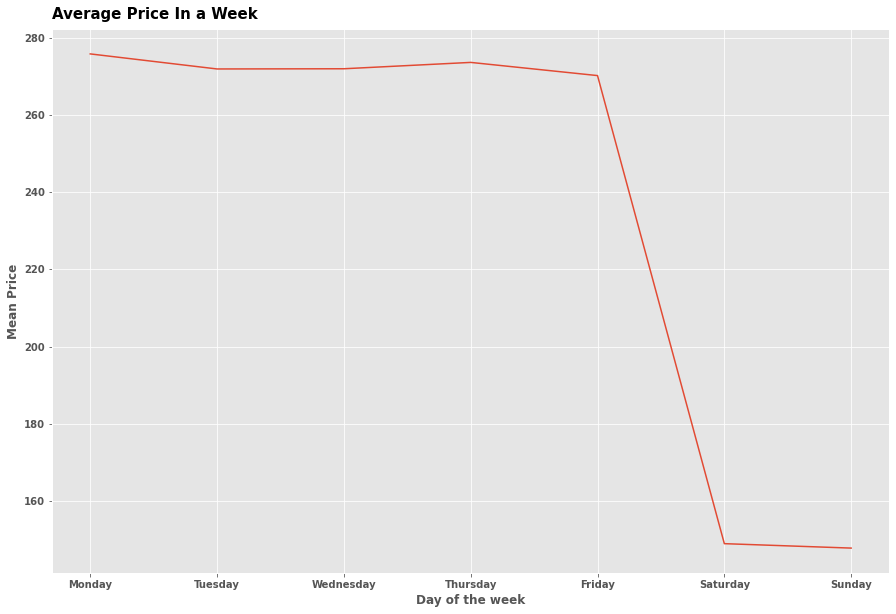

In [ ]:

mean_per_day = df.groupby("Day")["Close"].agg(["mean"])
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(mean_per_day.index,mean_per_day["mean"])
plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=1, weight="bold")
plt.yticks(alpha=1, weight="bold")
plt.xlabel("Day of the week",alpha=1, weight="bold")
plt.ylabel("Mean Price",alpha=1, weight="bold")
plt.title("Average Price In a Week", alpha=1, weight="bold", fontsize=15, loc="left", pad=10)

Text(0.0, 1.0, 'Stock Price from 2018 To 2023 Year')

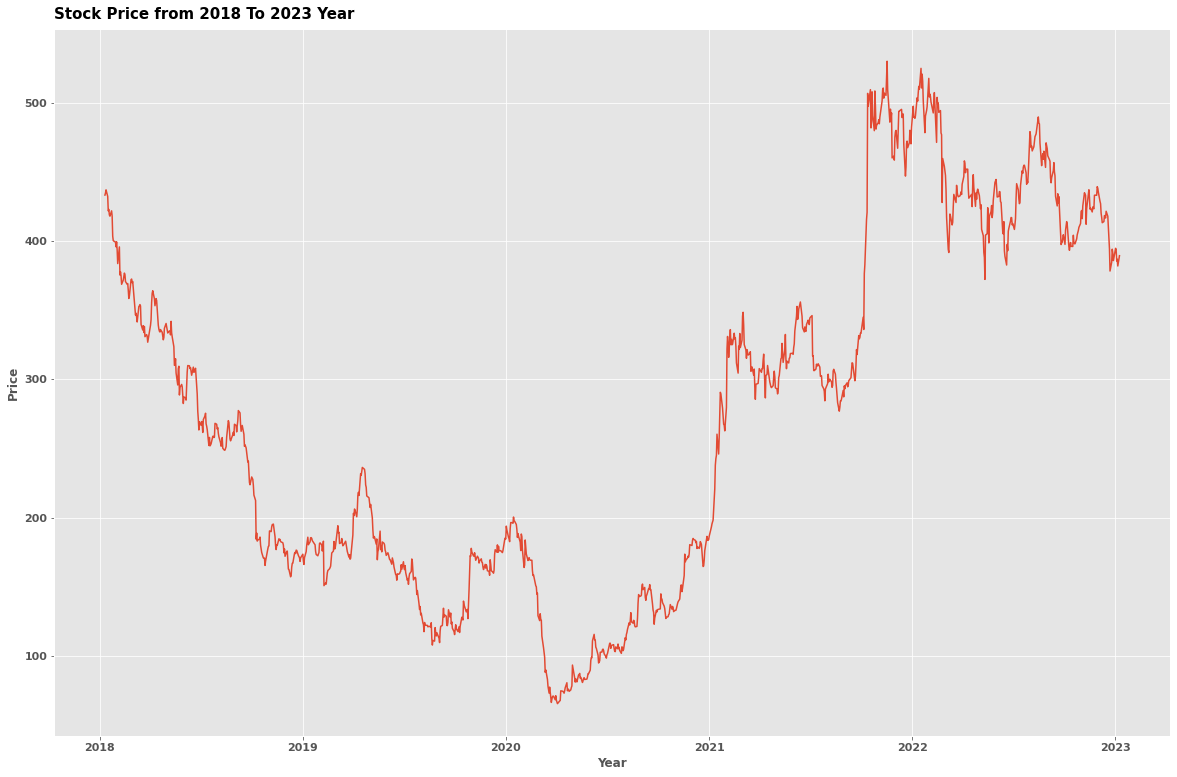

In [ ]:
fig,ax = plt.subplots(figsize=(20,13))
plt.plot(df.index,df["Close"])
plt.xlabel("Year", alpha=1, weight="bold")
plt.ylabel("Price", alpha=1, weight="bold")
plt.xticks(alpha=1,weight="bold", fontsize=11)
plt.yticks(alpha=1,weight="bold", fontsize=11)
plt.title("Stock Price from 2018 To 2023 Year", alpha=1, weight="bold", fontsize=15, pad=10, loc="left")

In [ ]:

def feature_holidays(row):

    if row["Drop_me"] == "01-01":
        return "New Year"
    if row["Drop_me"] == "04-07":
        return "Ind Day"
    if row["Drop_me"] == "11-28":
        return "Thanksgiving"
    if row["Drop_me"] == "12-25":
        return "Christmas"
    return 'Other'

def feature_weekend(row):
    if row["Day"] == 5 or row["Day"] == 6:
        return "Weekend"
    return "NonWeekend"

In [ ]:
df["Holiday"] = df.apply (lambda row : feature_holidays(row), axis=1)
df["Weekend"] = df.apply(lambda row: feature_weekend(row), axis=1)

In [ ]:
df = df.drop(["Drop_me"],axis=1)

In [ ]:
dummies = pd.get_dummies(df[["Holiday","Weekend"]],prefix="Dummy")
df = df.join(dummies,lsuffix="_left")
df = df.drop(df[["Holiday","Weekend"]], axis=1)

In [ ]:
train_test_date = "01-01-2021"
consum_test = df[df.index > train_test_date].copy()
consum_train = df[df.index <= train_test_date].copy()

In [ ]:
def lag_features(lag_dataset,period_list):

    temp_data = lag_dataset["Close"]

    for period in period_list:

        lag_dataset["lag_consumption_{}".format(period)] = temp_data.shift(period)
        lag_dataset["mean_rolling_{}".format(period)] = temp_data.rolling(period).mean()
        lag_dataset["max_rolling_{}".format(period)] = temp_data.rolling(period).max()
        lag_dataset["min_rolling_{}".format(period)] = temp_data.rolling(period).min()

    for column in lag_dataset.columns[20:]:

        lag_dataset[column] = lag_dataset[column].fillna(lag_dataset.groupby("Date")["Close"].transform("mean"))

    return lag_dataset

In [ ]:
consum_train = lag_features(consum_train,[5,10,15])

consum_test = lag_features(consum_test,[5,10,15])

Text(0.0, 1.0, 'Train - Test Split')

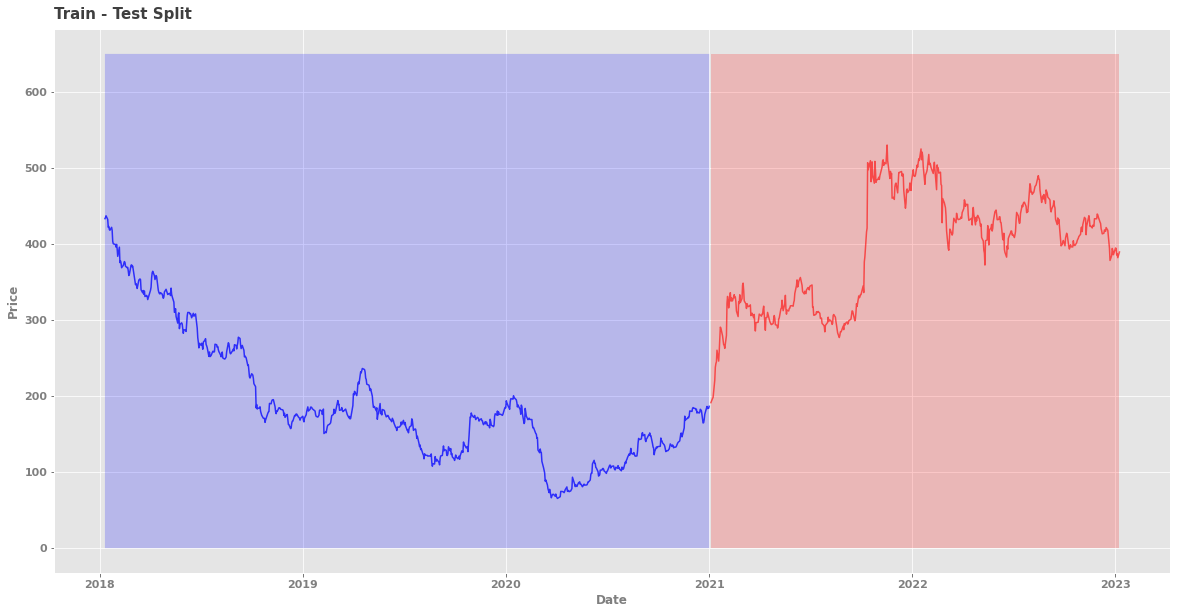

In [ ]:
fig,ax = plt.subplots(figsize=(20,10))

coloring = 650

plt.plot(consum_train.index,consum_train["Close"],color="blue", alpha=0.75)
plt.fill_between(consum_train.index,coloring, facecolor="blue", alpha=0.2)

plt.plot(consum_test.index,consum_test["Close"], color = "red", alpha=0.60)
plt.fill_between(consum_test.index,coloring, facecolor="red", alpha=0.2)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Price", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Train - Test Split", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [ ]:

X_train = consum_train.drop("Close", axis=1)
y_train = consum_train["Close"]
X_test = consum_test.drop("Close", axis=1)
y_test = consum_test["Close"]

In [ ]:
#XGBoost

xgd_reg = xgb.XGBRegressor(n_estimators=20000)

#XGBoost

#XGBoost

xgd_reg = xgb.XGBRegressor(n_estimators=1000)

xgd_reg.fit(X_train,y_train,
           eval_set=[(X_train,y_train),(X_test,y_test)],
           early_stopping_rounds=50,
           verbose=False)



[16:17:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(n_estimators=1000)

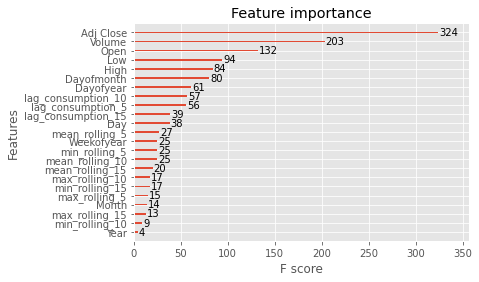

In [ ]:

plot_importance(xgd_reg)
plt.show()

In [ ]:
consum_test["Prediction"] = xgd_reg.predict(X_test)

Text(0.0, 1.0, 'Predicted Price')

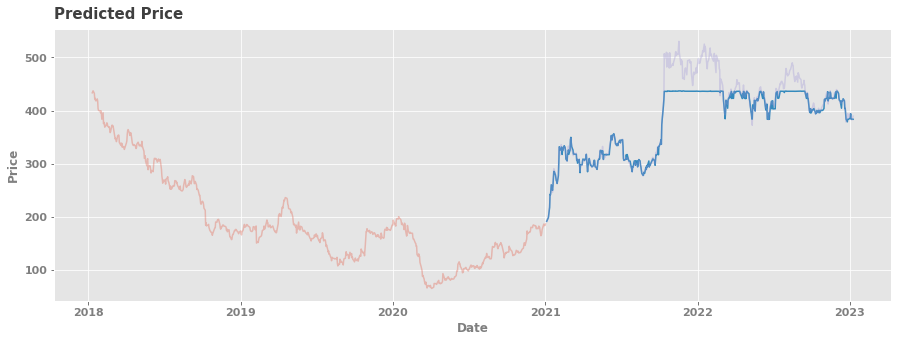

In [ ]:
fig,ax = plt.subplots(figsize=(15,5))

plt.plot(consum_train.index,consum_train["Close"],alpha=.3)
plt.plot(consum_test.index,consum_test["Prediction"])
plt.plot(consum_test.index,consum_test["Close"],alpha=.3)

plt.xlabel("Date", alpha=0.75, weight="bold")
plt.ylabel("Price", alpha=0.75, weight="bold")

plt.xticks(alpha=0.75,weight="bold", fontsize=11)
plt.yticks(alpha=0.75,weight="bold", fontsize=11)

plt.title("Predicted Price", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

Text(0.0, 1.0, 'Predicted Price')

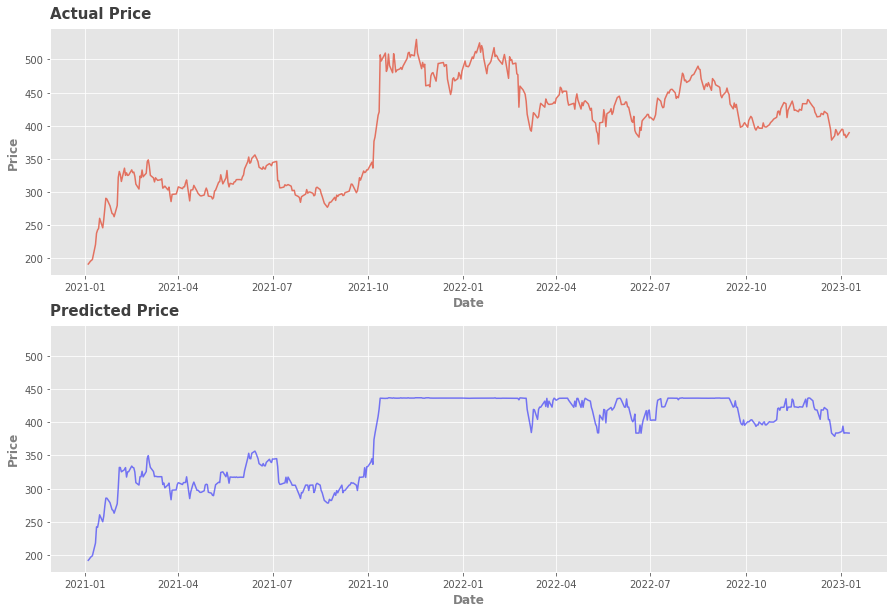

In [ ]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10),sharey=True)

ax1.plot(consum_test.index,consum_test["Close"],alpha=0.75)
ax2.plot(consum_test.index,consum_test["Prediction"],color="blue",alpha=0.50)

ax1.set_xlabel("Date", alpha=0.75, weight="bold")
ax1.set_ylabel("Price", alpha=0.75, weight="bold")
ax2.set_xlabel("Date", alpha=0.75, weight="bold")
ax2.set_ylabel("Price", alpha=0.75, weight="bold")

ax1.set_title("Actual Price", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")
ax2.set_title("Predicted Price", alpha=0.75, weight="bold", fontsize=15, pad=10, loc="left")

In [ ]:
mean_sq = mean_squared_error(y_test,xgd_reg.predict(X_test))
rmse = np.sqrt(mean_sq)

mean_abs_sq = mean_absolute_error(y_test,xgd_reg.predict(X_test))

print("Root Mean Squared Error : {}".format(rmse))
print("Mean Absolute Error : {}".format(mean_abs_sq))

Root Mean Squared Error : 26.629353382910768
Mean Absolute Error : 15.187667076585113


In [ ]:
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 KB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 KB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 KB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 KB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 KB 20.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 KB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 KB 6.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

In [ ]:
from pycaret.datasets import get_data
from pycaret.classification import *

ind = get_data("diabetes")

s = setup(ind, target="Class variable")
model = s.create_model('rf')

data_new = s.predict_model(model, data = ind)

,Number of times pregnant,Plasma glucose concentration a 2 hours in an oral glucose tolerance test,Diastolic blood pressure (mm Hg),Triceps skin fold thickness (mm),2-Hour serum insulin (mu U/ml),Body mass index (weight in kg/(height in m)^2),Diabetes pedigree function,Age (years),Class variable
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


,Description,Value
0,Session id,3980
1,Target,Class variable
2,Target type,Binary
3,Original data shape,"(768, 9)"
4,Transformed data shape,"(768, 9)"
5,Transformed train set shape,"(537, 9)"
6,Transformed test set shape,"(231, 9)"
7,Numeric features,8
8,Preprocess,True
9,Imputation type,simple


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7407,0.8549,0.5263,0.6667,0.5882,0.4028,0.4088
1,0.7593,0.7857,0.5789,0.6875,0.6286,0.4524,0.4561
2,0.7222,0.8038,0.5789,0.6111,0.5946,0.3836,0.3839
3,0.7778,0.8436,0.5789,0.7333,0.6471,0.4882,0.4954
4,0.7593,0.7797,0.4211,0.8000,0.5517,0.4081,0.4474
5,0.7037,0.7910,0.5263,0.5882,0.5556,0.3344,0.3355
6,0.7037,0.7692,0.6316,0.5714,0.6000,0.3656,0.3668
7,0.8302,0.8421,0.7222,0.7647,0.7429,0.6163,0.6168
8,0.7547,0.8667,0.6111,0.6471,0.6286,0.4457,0.4461


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.9284,0.9765,0.8731,0.9176,0.8948,0.8406,0.8412


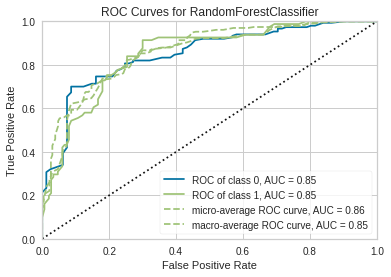

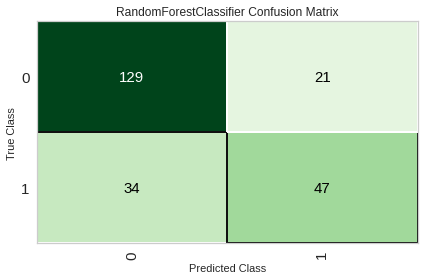

In [ ]:
s.plot_model(model,plot = 'auc')
s.plot_model(model,plot = 'confusion_matrix')